# AirBnB analysis of reviews from Washington DC
## Guy Harrington (13/11/2018)

## Introduction
Data from Airbnb are available for many cities around the world at http://insideairbnb.com/get-the-data.html and represent a wealth of information for modeling purposes. In this notebook I concentrate on the city of Washington DC in order to understand how reviews might reflect the different neighbourhoods. The city is diverse although gentrifying fast so that areas deemed unsafe even 5 years ago are now suitable for hosting visitings and AirBnB rentals. The quantity of data available and the computing power and time involved impose limitations on how the data can be analysed. 

The key question to this workflow are:-

1. Do the review comments reflect the neighbourhoods?

This can be explored by utilising the reviews of the listing id's, and extracting the words that are most relevant to each neighbourhood if it can be shown that certain words predict the neighbourhoods.

## Data preparation and workflow

The data were downloaded from the AirBnB site and relevant data sets are spread across two different .csv files. These were loaded, cleaned, prepared and then merged prior preprocessing and data analysis. The number of reviews available over time (the data are up to October 2018) mean that a decision is needed to chieve a good sample size for analysis that can reasonable run on a laptop. Hence, the top 10 ranked neighbourhoods that have >200 listings are carried forward for analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 

nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
##Load the reviews comments and check the df structure:
reviews_raw = pd.read_csv('C:/Users/GJH2018/Downloads/reviews.csv/reviews.csv') #laptop
reviews_raw.head()
# reviews_raw = pd.read_csv('C:/Thinkful/Thinkful_DS_course/Unit_4/Unit_4_capstone/reviews.csv/reviews.csv') #desktop
# reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3362,662,2009-01-21,6917,Robyn,Ayeh is a gracious and accommodating host. He...
1,3362,1099,2009-03-26,10492,Brian,"I stayed at Ayeh's place in March, and it was ..."
2,3362,6300,2009-07-28,22668,Anthony,"My 14 y.o. niece, her best friend and I stayed..."
3,3362,8387,2009-08-27,30379,Lina,We enjoyed the time with Ayeh in Washington ve...
4,3362,8451,2009-08-28,33059,Nicole,We also enjoyed our stay in DC while at Ayeh's...


In [3]:
#Load the listings id's and neighbourhood and other associated features:
listings_raw = pd.read_csv('C:/Users/GJH2018/Downloads/listings.csv')
listings_raw.head()

# listings_raw = pd.read_csv('C:/Thinkful/Thinkful_DS_course/Unit_4/Unit_4_capstone/listings.csv')
# listings_raw.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3362,"Convention Center Rowhouse & In Law: 2 Units, 4BR",2798,Ayeh,NaN,"Shaw, Logan Circle",38.910461,-77.019331,Entire home/apt,433,2,150,2018-09-21,1.27,5,324
1,3662,Vita's Hideaway II,4645,Vita,NaN,Historic Anacostia,38.861925,-76.989634,Private room,65,2,35,2018-06-02,0.38,3,364
2,3686,Vita's Hideaway,4645,Vita,NaN,Historic Anacostia,38.863138,-76.988362,Private room,55,2,67,2017-10-29,0.69,3,365
3,3771,Mt. Pleasant,4795,Charlene,NaN,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.927605,-77.039265,Private room,88,1,1,2009-01-21,0.01,1,0
4,4002,2 Bedroom Private Condo Suite (Basement Apt),5143,Anthony,NaN,"North Michigan Park, Michigan Park, University...",38.940084,-76.989360,Entire home/apt,120,2,148,2018-08-03,1.25,1,361


In [4]:
##Merge the two df on 'listing_id' and 'id that refer to the property'

reviews_master = pd.merge(reviews_raw, listings_raw, 
                          left_on='listing_id',
                          right_on='id')

reviews_master.shape

(277003, 22)

In [78]:
##Cut out columns that are not required. There are many columns here that could be used in a bigger study:
reviews_raw_cut = reviews_master[['listing_id', 'comments','room_type','price', 'neighbourhood','date']]

##Cut the data down to the last year only
from datetime import datetime #column is a datetime object.
reviews_2018 = reviews_raw_cut[reviews_raw_cut['date'] > '2017-10-10'] 
reviews_2018.shape

##Check the number of neighbourhood reviews:
#pd.crosstab(reviews_cut['neighbourhood'],reviews_cut['room_type'],margins=True)

##Convert the comments column into strings because it contains numbers and other symbols
reviews_2018['comments'] = reviews_2018['comments'].astype(str)

##Group the comments for each property. The comments for each property are across their own rows.
comments_combined = reviews_2018.groupby(['listing_id','neighbourhood'])['comments'].apply(lambda x: x.sum())

C:\Users\GJH2018\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [79]:
##Group the prices together. These change over time so average values are required. This column maybe required later.
prices_average_2018 = reviews_2018.groupby('listing_id')['price'].mean()
prices_average_2018.shape


(5849,)

In [80]:
##Convert the lists into dfs so that they can be merged with the other features before it is cleaned and modeled.
df_comments = pd.DataFrame(comments_combined).reset_index()
df_comments_columns = ['listing_id','neighbourhood', 'comments']

df_price = pd.DataFrame(prices_average_2018).reset_index()
df_price_columns = ['listing_id','av_price']

##Check they have the same number of rows!:
print('df_comments shape: {}'.format(df_comments.shape))
print('df_price shape: {}'.format(df_price.shape))

df_comments shape: (5849, 3)
df_price shape: (5849, 2)


In [81]:
##Merge the comments df and the price df so there is one final raw dataframe for preprocessing:
reviews_df = df_comments.merge(df_price, on='listing_id')

##Change column order so that Y is at [0] and X is at [1]
reviews_df = reviews_df[['neighbourhood','comments','listing_id','price']]
reviews_df.head()

,neighbourhood,comments,listing_id,price
0,"Shaw, Logan Circle",This house and basement apartment was perfect ...,3362,433
1,Historic Anacostia,I’d have to write for days if I can try to exp...,3662,65
2,Historic Anacostia,"Great house, didn’t get a chance to meet Vita ...",3686,55
3,"North Michigan Park, Michigan Park, University...","Muy Amplio, fácil de llegar y acceder a la cui...",4002,120
4,"Capitol Hill, Lincoln Park",This AirBnb is in a GREAT location! Easy walk ...,4197,83


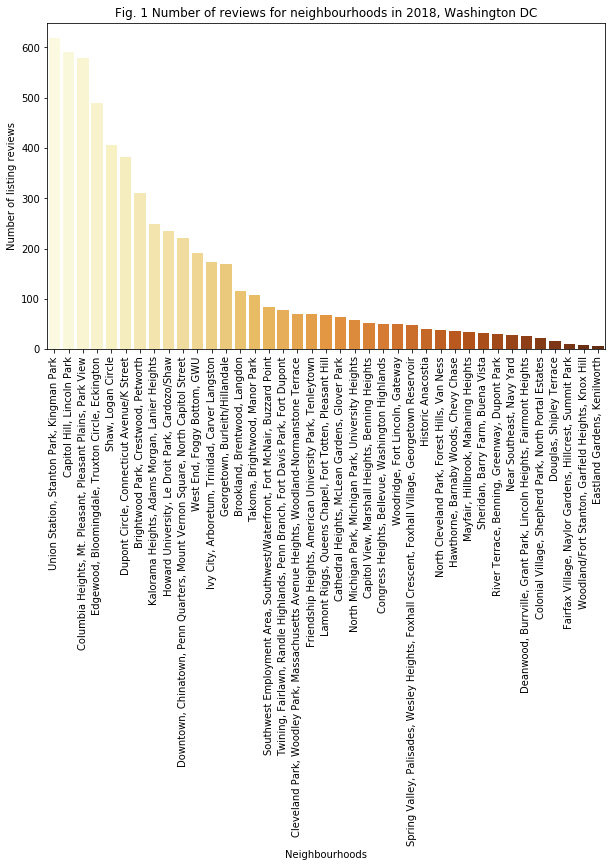

In [15]:
neighbourhood_count = reviews_df['neighbourhood'].value_counts()

plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.barplot(neighbourhood_count.index, neighbourhood_count.values, palette='YlOrBr')
plt.title('Fig. 1 Number of reviews for neighbourhoods in 2018, Washington DC')
plt.ylabel('Number of listing reviews', fontsize=10)
plt.xlabel('Neighbourhoods', fontsize=10)
plt.xticks(rotation='vertical')
plt.show()

**Fig. 1** The number of reviews by neighbouthood for the one year window from October 2017 - October 2018 for neighbourhoods in Washington DC as definied by AirBnB. Only those with >200 reviews (in this case proprties with reviews) are carried forward for analysis. These are the top 10 ranked neighbourhods by properties in AirBnB for Washington DC. 

To help mitigate against class imbalance and to help speed-up processing time, the dataset is pruned further:

In [83]:
##Cut the df back to 2018 and to the neighbours with >200 listing_id reviews
counts = reviews_df['neighbourhood'].value_counts()
counts[counts > 200]
reviews_df = reviews_df[reviews_df['neighbourhood'].isin(counts[counts > 200].index)]

In [4]:
#Convert neighbourhoods into numeric categories
from io import StringIO

reviews_df['neighbourhood_id']  = reviews_df['neighbourhood'].factorize()[0] #Converts into integers

reviews_id_df = reviews_df[['neighbourhood', 'neighbourhood_id']].drop_duplicates().sort_values('neighbourhood_id')

#Make two disctionaries for use further in the workflow:
reviews_to_id = dict(reviews_id_df.values)
id_to_category = dict(reviews_id_df[['neighbourhood_id', 'neighbourhood']].values)

reviews_df.head()
#reviews_df.to_csv('reviews_df.csv')

,Unnamed: 0,neighbourhood,comments,listing_id,price,neighbourhood_id
0,0,"Shaw, Logan Circle",This house and basement apartment was perfect ...,3362,433,0
1,4,"Capitol Hill, Lincoln Park",This AirBnb is in a GREAT location! Easy walk ...,4197,83,1
2,5,"Kalorama Heights, Adams Morgan, Lanier Heights",Eddie and Joanie's are wonderful hosts! The pl...,4283,130,2
3,7,"Kalorama Heights, Adams Morgan, Lanier Heights",We had a really nice time staying at Ami’s pla...,5589,118,2
4,8,"Brightwood Park, Crestwood, Petworth","The space is enormous (basement, of course, so...",6165,65,3


### Preprocessing steps
The dataframe (reviews_df) requires that the text is cleaned, then tokenised, punctuation needs removing, stopwords removed and the turned into a bag of words before modelling. The steps to assembled the comments column indicate that some repetitive text (and numbers) need removing.

In [31]:
data = []

for i in range(reviews_df.shape[0]):
    sms = reviews_df.iloc[i, 1]

    ##remove non alphabatic characters
    sms = re.sub('[^A-Za-z]', ' ', sms)
    
    ##Remove basic HTML
    sms = re.sub('<[^>]*>', '', sms) 
    
    ##make words lowercase, because Go and go will be considered as two words
    sms = sms.lower()
    
    ##Remove automated text
    sms = sms.replace('host canceled this reservation', '') 
    sms = sms.replace('days before arrival','')
    sms = sms.replace('automated posting', '')
    
    ##tokenising
    tokenized_sms = wt(sms)

    ##remove stop words and stemming
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append((lemmatizer.lemmatize(word)))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

In [33]:
#data_tokenized = pd.DataFrame(data)
#data_tokenized.to_csv('Tokenized_review_data.csv')
#X = pd.read_csv('C:/Users/harri/Dropbox/Thinkful/Thinkful_DS_course/Unit_4/Unit_4_capstone/Tokenized_review_data.csv')

#data = pd.read_csv('Tokenized_review_data.csv')
#data = list(data.values.flatten())
#len(data)

In [34]:
# create the feature matrix. Gets 1000 most important features

from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000,min_df=5)
X = matrix.fit_transform(data).toarray()
y = reviews_df.iloc[:, 0] #This is the column of neighbourhoods


In [35]:
#CountVectorizer returns a matrix, the rows are the sms and the columns are the 1000 features.
print(X.shape)
print(y.shape)


(4080, 1000)
(4080,)


In [49]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y)

# Models:

To assess the performance of different models, the parameters were tuned on the training sets. Both Naive Bayes and Logstic Regression have shown good results in previous studies on text analysis of sparse matrices. These are compared with a Random Forest and the features extracted. Gradient Boosting Classifier was attempted but this requires significant parameter tuning, and time to train and was beyond the resources of the computer available. It was therefore decided to continue with the Random Forest as a suitable tree ensemble method.

### Naive Bayes

In [37]:
# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
# predict class
y_pred = classifier.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred) #Use for plotting a heatmap
cr = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy) #0.5058823529411764 without lemmas

0.5078431372549019


In [39]:
feature_names = matrix.get_feature_names()

print('Number of features: {}'.format(len(feature_names)))
print('First of 20 features:\n{}'.format(feature_names[:20]))
print('Every 100th feature:\n{}'.format(feature_names[::100]))

Number of features: 1000
First of 20 features:
['able', 'absolutely', 'ac', 'access', 'accessible', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accurate', 'across', 'activity', 'actually', 'adam', 'add', 'added', 'addition', 'adorable', 'adult', 'advertised']
Every 100th feature:
['able', 'block', 'convention', 'etc', 'heard', 'lively', 'nightlife', 'quite', 'smithsonian', 'townhouse']


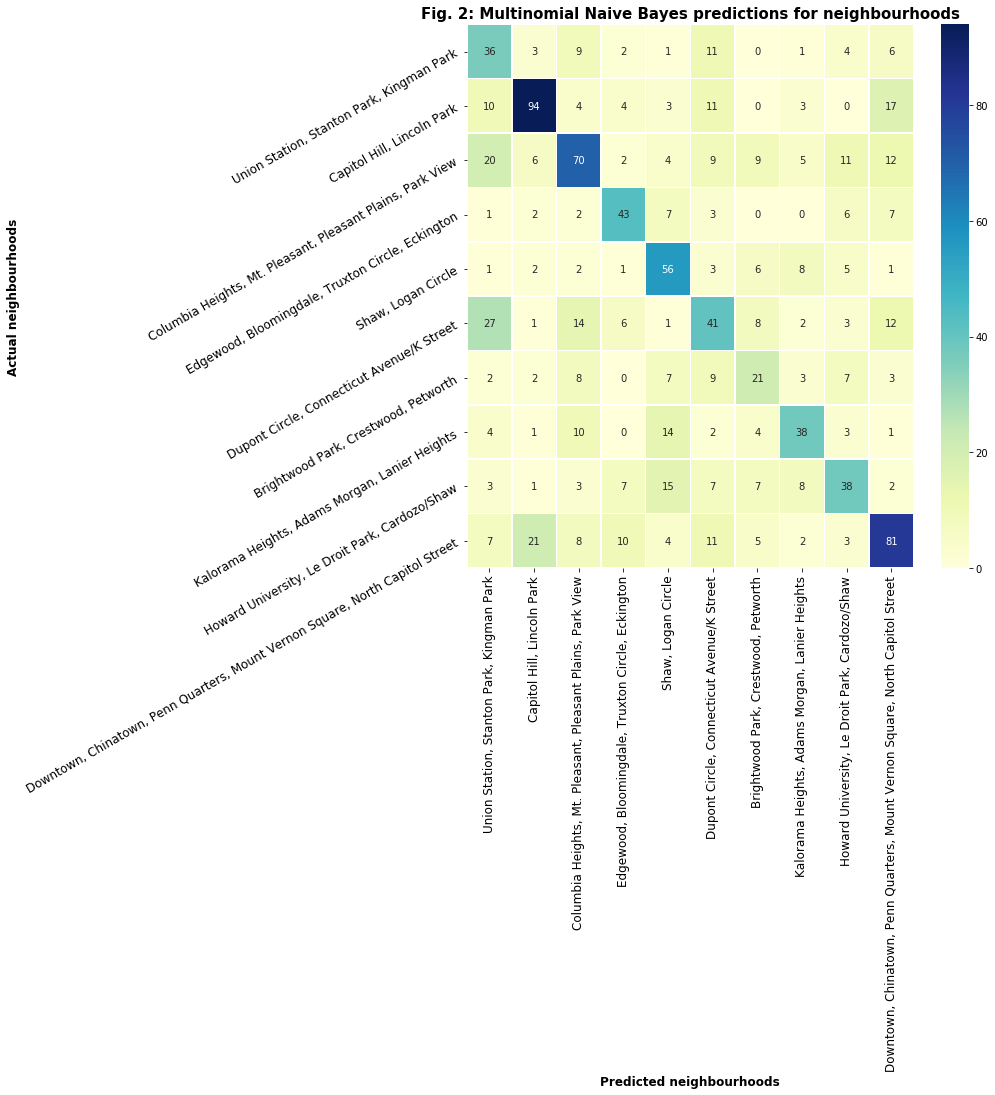

In [40]:
##Plot the predicted against the actual neighbourhoods:

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, cmap='YlGnBu', xticklabels = neighbourhood_count.index[:10], yticklabels=neighbourhood_count.index[:10])
ax.set_ylabel('Actual neighbourhoods', fontsize=12, weight='bold')
ax.set_xlabel('Predicted neighbourhoods', fontsize=12, weight='bold')
ax.set_title('Fig. 2: Multinomial Naive Bayes predictions for neighbourhoods', fontsize=15, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_xticklabels(),rotation=30)
ax.tick_params(labelsize=12)

#plt.savefig('MultinomialNB_confusion_matrix.png',dpi=400,bbox_inches='tight')
plt.show()

**Fig. 2** A heatmap of the confusion matrix for multinomial naive bayes showing how th actual and predicted neighbourhoods correspond. Some of the predictions are poor but some of these are missed predictions are for areas or neighbourhoods that are next to one another (e.g. Downtown that is directly adjoining Capitol Hill and 1 stop on the metro from Dupont Circle). 

Clearly, the model is missing a lot of information about neighbourhoods and is misclassifying. To understand why it is not classifying, the text can be examined using other models incase Naive Bayes is not the strongest representation of the data.

### Logistic Regression

In [51]:
##Run logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train,y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross-validation score: 0.54
Best parameters:  {'C': 0.01}


### Random Forest Classifier

In [22]:
##Tune parameters for Random Forest Classifier
param_grid = {'n_estimators':[300, 400, 500],
             'max_depth': [50, 55, 60]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train,y_train)

print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)


Best cross-validation score: 0.54
Best parameters:  {'max_depth': 50, 'n_estimators': 500}


In [53]:
'''
Run Random Forest, multinomial Naive Bayes, and logistic regression to see how they perform and how an ensemble 
of them performs using the VotingClassifier function.'''

rfc = RandomForestClassifier(n_estimators=500, max_depth=50, random_state=0)
nb = MultinomialNB()
lr = LogisticRegression(C=0.01, random_state=0)

models = [nb, lr, rfc,
           VotingClassifier(estimators=[('nb', nb),('lr',lr),('rfc', rfc)],
                            voting='hard')]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV, n_jobs=-1)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx', 'accuracy'])



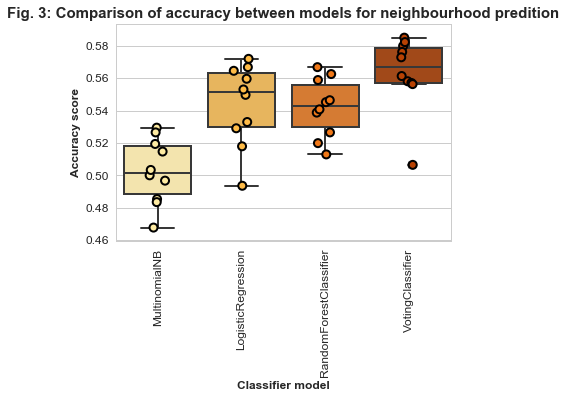

In [50]:
##Plot the results
plt.figsize = (20,20)

sns.set(style="whitegrid")
ax = sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette='YlOrBr', linewidth=2)
ax = sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, 
                   jitter=True, edgecolor="black",linewidth=2, palette='YlOrBr')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title('Fig. 3: Comparison of accuracy between models for neighbourhood predition',weight='bold', fontsize=15)
ax.set_xlabel('Classifier model',fontsize=12, weight='bold')
ax.set_ylabel('Accuracy score',fontsize=12, weight='bold')
ax.tick_params(labelsize=12)

#plt.savefig('NLP_Model_comparisons_training_data_ALL_models.png',dpi=400,bbox_inches='tight')
plt.show()


**Fig. 3:** Boxplots of the 10 cross-validations on three different models for predicting neighbourhood and an ensemble solution using VotingClassifier that is significantly more robust by c. 4% that is the typical for an ensemble of different methods. 

In [54]:
##Check the accuracy of the models:

print('Mean of model CVs:\n \n' + str(cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False))
      + '\n\nSTD of model CVs: \n\n' + str(cv_df.groupby('model_name').accuracy.std().sort_values(ascending=False)))

Mean of model CVs:
 
model_name
VotingClassifier          0.563089
RandomForestClassifier    0.550007
LogisticRegression        0.543155
MultinomialNB             0.500620
Name: accuracy, dtype: float64

STD of model CVs: 

model_name
LogisticRegression        0.024458
VotingClassifier          0.023849
MultinomialNB             0.017755
RandomForestClassifier    0.015746
Name: accuracy, dtype: float64


There may be several reasons why the models are not performing well. These may relate to the geographic distance between neighbourhoods such that they are not really discrete but merge. The categories defined by AirBnB are arbitrary to some degree and binarize the data in way that is not conducive for analysing spatial data. Some properties may be one block from one another but scored in a different neighbourhood.

The other compounding issues may relate to the way the text has been cleaned and prepared. Maybe lemmatizing and tokening into bag of words as n_gram =1 is just too coarse. The reason neighbourhoods map onto some words in the models may be because they actually contain the name of that neighbourhood so will self-validate. An alternative approach is to use term-frequency  inverse document frequency (tfidf) vectorizing to penalize text tat appears frequently and to also increase the number of words in the n-gram bag of words although this may lose power of prediction over individual words.

# Tfidf modelling approach

In [2]:
##Use the reviews_df that is the result of the steps above up until the 'preprocessing step'. If necessary load again:
reviews_df = pd.read_csv('reviews_df.csv')

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# - sublinear_df is set to True to use a logarithmic form for frequency.
# - min_df is the minimum numbers of documents a word must be present in to be kept.
# - norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# - ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# - stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(reviews_df.comments).toarray()
labels = reviews_df.neighbourhood_id

features.shape

(4080, 59018)

In [3]:
#Convert neighbourhoods into numeric categories
from io import StringIO

reviews_df['neighbourhood_id']  = reviews_df['neighbourhood'].factorize()[0] #Converts into integers

reviews_id_df = reviews_df[['neighbourhood', 'neighbourhood_id']].drop_duplicates().sort_values('neighbourhood_id')

#Make two disctionaries for use further in the workflow:
reviews_to_id = dict(reviews_id_df.values)
id_to_category = dict(reviews_id_df[['neighbourhood_id', 'neighbourhood']].values)

reviews_df.head()
#reviews_df.to_csv('reviews_df.csv')

,Unnamed: 0,neighbourhood,comments,listing_id,price,neighbourhood_id
0,0,"Shaw, Logan Circle",This house and basement apartment was perfect ...,3362,433,0
1,4,"Capitol Hill, Lincoln Park",This AirBnb is in a GREAT location! Easy walk ...,4197,83,1
2,5,"Kalorama Heights, Adams Morgan, Lanier Heights",Eddie and Joanie's are wonderful hosts! The pl...,4283,130,2
3,7,"Kalorama Heights, Adams Morgan, Lanier Heights",We had a really nice time staying at Ami’s pla...,5589,118,2
4,8,"Brightwood Park, Crestwood, Petworth","The space is enormous (basement, of course, so...",6165,65,3


In [4]:
##Find the terms most correlated with with each neighbourhood:

from sklearn.feature_selection import chi2

N = 3
for neighbourhood, neighbourhood_id in sorted(reviews_to_id.items()):
  features_chi2 = chi2(features, labels == neighbourhood_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n## '{}':".format(neighbourhood))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("\n  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


## 'Brightwood Park, Crestwood, Petworth':
  . Most correlated unigrams:
. timber
. homestead
. petworth

  . Most correlated bigrams:
. petworth neighborhood
. wonderful nights
. timber pizza

## 'Capitol Hill, Lincoln Park':
  . Most correlated unigrams:
. capitol
. hill
. eastern

  . Most correlated bigrams:
. market metro
. capitol hill
. eastern market

## 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View':
  . Most correlated unigrams:
. target
. columbia
. heights

  . Most correlated bigrams:
. mt pleasant
. heights metro
. columbia heights

## 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street':
  . Most correlated unigrams:
. pool
. chinatown
. walmart

  . Most correlated bigrams:
. fitness center
. walmart starbucks
. view rooftop

## 'Dupont Circle, Connecticut Avenue/K Street':
  . Most correlated unigrams:
. mark
. circle
. dupont

  . Most correlated bigrams:
. near dupont
. circle metro
. dupont circle

## 'Edgewood, Bloomingdale

As anticipated, the words most associated with neighbourhoods tend to be the names of the neighbourhoods! There are some other interesting terms here that are related to sights or venues (e.g. convention center) or major key-stone stores like 'Target' and 'Walmart'. It appears that while there may be some nuggets of interesting information here, the words most correlated with unigrams and bigrams are not informative and are just autocorrelative.

It is still worth assessing whether the results from modelling are better using just the tfidf approach, that took less than 2 minutes to process the data, rather than the 25-30 minutes that the preprocessing step in the initial bag-of-words rendering achieved.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(reviews_df['comments'], reviews_df['neighbourhood'], random_state = 0)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [5]:
##Make some predictions to see how this works:
print(clf.predict(count_vect.transform(["The apartment was fantastic and very close to the nearest metro on the Red line. Recommend Annies on 17th Street"])))
#Actually I was thinking of Dupont Circle and Annies is a great diner!

['Union Station, Stanton Park, Kingman Park']


In [12]:
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
nb = MultinomialNB()
lr = LogisticRegression(C=0.01, random_state=0)
lsv = LinearSVC(random_state=0)

models = [rfc, nb,lr, lsv,
         VotingClassifier(estimators=[('nb', nb),('lr',lr),('rfc', rfc),('lsv', lsv)],
                            voting='hard')]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\harri\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\harri\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\harri\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\harri\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

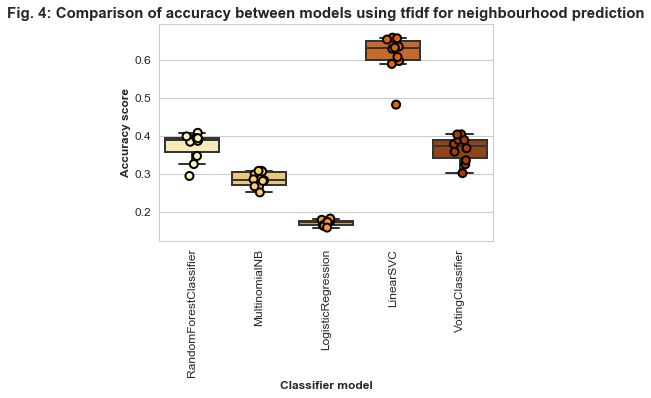

In [13]:
##Plot the results
plt.figsize = (20,20)

sns.set(style="whitegrid")
ax = sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette='YlOrBr', linewidth=2)
ax = sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, 
                   jitter=True, edgecolor="black",linewidth=2, palette='YlOrBr')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title('Fig. 4: Comparison of accuracy between models using tfidf for neighbourhood prediction',weight='bold', fontsize=15)
ax.set_xlabel('Classifier model',fontsize=12, weight='bold')
ax.set_ylabel('Accuracy score',fontsize=12, weight='bold')
ax.tick_params(labelsize=12)

#plt.savefig('NLP_Model_comparisons_training_data_ALL_models.png',dpi=400,bbox_inches='tight')
plt.show()

**Fig. 4** This shows the different models, including LinearSVC this time, for the tfidf dataset in predicting neighbourhood. This text has not otherwise been cleaned. 

The results from the tfidf show that all predictions are worse than using the bag of words as initially implemented. The Linear SVC appears to perform well in comparison. Hence, this model is carried forward to extract further information about comments on the different neighbourhoods in Washington DC. In this particular ensemble model, the VotingClassifier performs worse than the LinearSVC and the error messages imply there are empty features in the array.

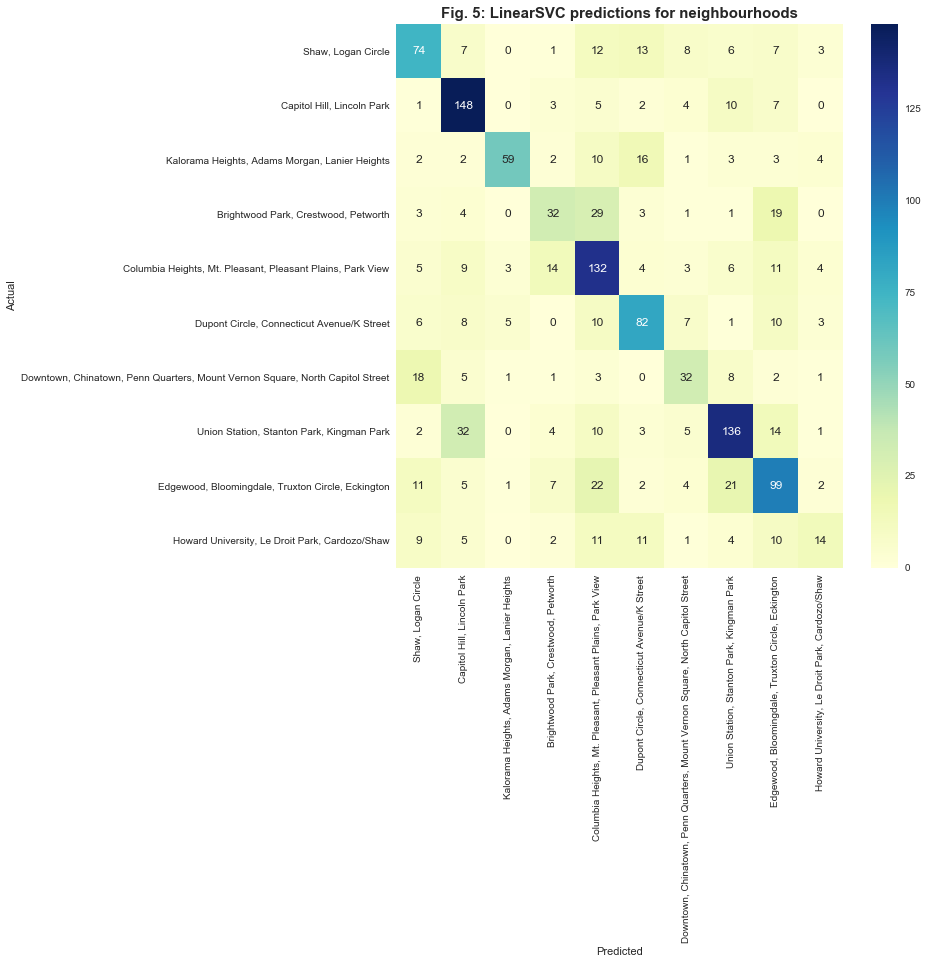

In [14]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, reviews_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=reviews_id_df.neighbourhood.values, yticklabels=reviews_id_df.neighbourhood.values)
ax.set_title('Fig. 5: LinearSVC predictions for neighbourhoods', fontsize=15, weight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**Fig. 5.** Linear Support Vector Machine for the neighbourhoods using the tfidf transformed features. Many predictions are on the diagonal but there are still plenty of misses for some of the neighbourhoods.

To gain insight into some of the misses, these can be extracted to see whether there is a pattern. Since the neighbourhood names will correlate strongly with the neighbourhoods and the geographic component is still present, the mismatch is likely due to discrete variables on a continuous variable map.

In [15]:
from IPython.display import display
for predicted in reviews_id_df.neighbourhood_id:
  for actual in reviews_id_df.neighbourhood_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(reviews_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['neighbourhood', 'comments']])
      print('')

'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street' predicted as 'Shaw, Logan Circle' : 18 examples.


,neighbourhood,comments
1770,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Kaleb's place is right in the heart of the cit...
3027,"Downtown, Chinatown, Penn Quarters, Mount Vern...",great locality and a good place to stay. but y...
1236,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Sarah is a great host. Place was nice and clea...
302,"Downtown, Chinatown, Penn Quarters, Mount Vern...",The price of housing corresponds to the qualit...
189,"Downtown, Chinatown, Penn Quarters, Mount Vern...","Great apartment, perfect location, very respon..."
4047,"Downtown, Chinatown, Penn Quarters, Mount Vern...",This is a great apartment that is in an awesom...
3086,"Downtown, Chinatown, Penn Quarters, Mount Vern...","Overall, this place is of high value due to th..."
1386,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Perfect location for exploring the national ma...
1513,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Great location and value. Good choice for a b...
480,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Awesome host! Great place and highly recommend...



'Edgewood, Bloomingdale, Truxton Circle, Eckington' predicted as 'Shaw, Logan Circle' : 11 examples.


,neighbourhood,comments
2549,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Very welcoming place! Great place to stay. Goo...
2556,"Edgewood, Bloomingdale, Truxton Circle, Eckington",It was more than perfect. Everything was clean...
638,"Edgewood, Bloomingdale, Truxton Circle, Eckington",This was our first experience with Airbnb and ...
2063,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Good recommendation!Great host! Goes above an...
2554,"Edgewood, Bloomingdale, Truxton Circle, Eckington",John is an excellent host. He gives you space ...
2230,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Even though we stayed at Gerards place for jus...
2409,"Edgewood, Bloomingdale, Truxton Circle, Eckington",I enjoyed my stay at Peter's house. I was made...
981,"Edgewood, Bloomingdale, Truxton Circle, Eckington",We rented Maria's unit for my in-laws visiting...
1505,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Staying in Renee's place was a truly amazing e...
1721,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Its a lovely, comfortable place in a safe and ..."



'Union Station, Stanton Park, Kingman Park' predicted as 'Capitol Hill, Lincoln Park' : 32 examples.


,neighbourhood,comments
1310,"Union Station, Stanton Park, Kingman Park",We were visiting DC for 3 nights and were luck...
1780,"Union Station, Stanton Park, Kingman Park",Fantastic house in a great location. Much reco...
2013,"Union Station, Stanton Park, Kingman Park",What we loved... EVERYTHING! This was only my ...
3403,"Union Station, Stanton Park, Kingman Park",Great Capitol Hill location. Walking distance ...
1509,"Union Station, Stanton Park, Kingman Park",My family of four had a wonderful quick trip t...
3952,"Union Station, Stanton Park, Kingman Park",Cerca de los\r\nLugares a visitar. Tranquilidad.
378,"Union Station, Stanton Park, Kingman Park",James and Nicole was really hospititable and n...
333,"Union Station, Stanton Park, Kingman Park","This is a fantastic place to stay, close to th..."
1972,"Union Station, Stanton Park, Kingman Park","Great place, close to the Capitol area. Had e..."
3565,"Union Station, Stanton Park, Kingman Park",L'emplacement de la maison d'Elika est excepti...



'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' predicted as 'Brightwood Park, Crestwood, Petworth' : 14 examples.


,neighbourhood,comments
1327,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",It’s jsut as described. I enjoyed my stay at t...
3003,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","Mary was very helpful and nice, with a good an..."
1712,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",My family's stay at Patrick and Rob's home was...
3757,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",The house is quite far from the metro but real...
917,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",This space was great for us. We had a large gr...
2678,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",Erins' place was exactly what is communicated....
3885,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",Just a quiet little place in the middle of the...
104,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","Great host. Clean place. Beautiful, cozy space..."
2337,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",A magnificent home in a beautiful neighborhood...
1625,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","First, the place is stellar! Central location,..."



'Shaw, Logan Circle' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 12 examples.


,neighbourhood,comments
1525,"Shaw, Logan Circle",I've stayed at Megan's before and it's always ...
1420,"Shaw, Logan Circle",Thank you so much. The location of the apartme...
1303,"Shaw, Logan Circle",Great host and great location!The location is ...
1220,"Shaw, Logan Circle",Everything was fine until we discovered a rode...
4056,"Shaw, Logan Circle",A quiet comfy place in a beautiful neighborhoo...
1958,"Shaw, Logan Circle",The place was great. Very clean. Jonathan was ...
276,"Shaw, Logan Circle",Everything was great as expected. Chris was a ...
2143,"Shaw, Logan Circle","Andrew was a great host, although we never met..."
1471,"Shaw, Logan Circle","Great, affordable place in the best neighborho..."
4057,"Shaw, Logan Circle",Walking distance to many nice bars and restaur...



'Kalorama Heights, Adams Morgan, Lanier Heights' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 10 examples.


,neighbourhood,comments
1082,"Kalorama Heights, Adams Morgan, Lanier Heights",Arlene was a great host. She answered all of o...
3822,"Kalorama Heights, Adams Morgan, Lanier Heights","David's place is beautiful, clean, and relaxin..."
3407,"Kalorama Heights, Adams Morgan, Lanier Heights",The host canceled this reservation 6 days befo...
3222,"Kalorama Heights, Adams Morgan, Lanier Heights",Craig is a great host and the apartment was sp...
569,"Kalorama Heights, Adams Morgan, Lanier Heights",Alles so wie beschrieben vorgefunden. Sehr gut...
226,"Kalorama Heights, Adams Morgan, Lanier Heights","Jennifer's place was a great, stylish home awa..."
1266,"Kalorama Heights, Adams Morgan, Lanier Heights",An inviting immaculate compact space in a beau...
1496,"Kalorama Heights, Adams Morgan, Lanier Heights","This is a clean, cute, and centrally located a..."
3718,"Kalorama Heights, Adams Morgan, Lanier Heights","Julia's place was fantastic, and she was an ou..."
1148,"Kalorama Heights, Adams Morgan, Lanier Heights",Great location. Easy to communicate with the h...



'Brightwood Park, Crestwood, Petworth' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 29 examples.


,neighbourhood,comments
485,"Brightwood Park, Crestwood, Petworth","Miriam was a fantastic host, definitely one of..."
1363,"Brightwood Park, Crestwood, Petworth",They accommodated dates and were amazing host....
576,"Brightwood Park, Crestwood, Petworth",Kristen's apartment was perfect! Great locatio...
142,"Brightwood Park, Crestwood, Petworth",I've stayed for around 2months. It is really n...
751,"Brightwood Park, Crestwood, Petworth",The location is convenient because it is relat...
49,"Brightwood Park, Crestwood, Petworth",I can not say enough good things about Natasha...
2476,"Brightwood Park, Crestwood, Petworth",Abby's place is super nice! We stayed there fo...
3527,"Brightwood Park, Crestwood, Petworth",I needed a place for a night last minute and t...
3352,"Brightwood Park, Crestwood, Petworth","The place was clean, stylish, and more spaciou..."
3009,"Brightwood Park, Crestwood, Petworth",Richard's place is very clean and comfy with g...



'Dupont Circle, Connecticut Avenue/K Street' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 10 examples.


,neighbourhood,comments
3629,"Dupont Circle, Connecticut Avenue/K Street",This house was in a very convenient location. ...
690,"Dupont Circle, Connecticut Avenue/K Street",Great place. Particularly enjoyed sitting on t...
2751,"Dupont Circle, Connecticut Avenue/K Street",This is a great house! The host was friendly ...
4075,"Dupont Circle, Connecticut Avenue/K Street",Nice like cozy apartment! Host was awesome and...
1526,"Dupont Circle, Connecticut Avenue/K Street",A great space in a great location. Only a walk...
3910,"Dupont Circle, Connecticut Avenue/K Street",Very comfortable and well-equipped space! Rach...
2412,"Dupont Circle, Connecticut Avenue/K Street","Great space, but the hallway on the fourth flo..."
3785,"Dupont Circle, Connecticut Avenue/K Street",Very welcoming and pleasant host to share spac...
852,"Dupont Circle, Connecticut Avenue/K Street",Our stay at Brian's place was unexpected becau...
320,"Dupont Circle, Connecticut Avenue/K Street","Place like home :)Great place to stay, super f..."



'Union Station, Stanton Park, Kingman Park' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 10 examples.


,neighbourhood,comments
2948,"Union Station, Stanton Park, Kingman Park",.
1280,"Union Station, Stanton Park, Kingman Park",The host canceled this reservation 23 days bef...
1739,"Union Station, Stanton Park, Kingman Park",Very pleasant atmosphere and great location. W...
1261,"Union Station, Stanton Park, Kingman Park",Jamie's apartment is beautifully renovated and...
2052,"Union Station, Stanton Park, Kingman Park",We were shocked by how beautiful the place is ...
1285,"Union Station, Stanton Park, Kingman Park",I would definitely stay here againAwesome plac...
3776,"Union Station, Stanton Park, Kingman Park",Phillip is very easy to communicate with and i...
1784,"Union Station, Stanton Park, Kingman Park",I spent just under two weeks at this quiet lit...
3450,"Union Station, Stanton Park, Kingman Park",THE MOST THOUGHTFUL AND AMAZING HOSTS!! The ap...
4014,"Union Station, Stanton Park, Kingman Park","New hosts, GREAT people. Really tried hard to ..."



'Edgewood, Bloomingdale, Truxton Circle, Eckington' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 22 examples.


,neighbourhood,comments
3898,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Beautiful Place, Beautiful Location, Great Hos..."
45,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Beulah was an amazing host. She was incredibly...
1059,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Had a lovely stay in Bloomingdale! I was in to...
1947,"Edgewood, Bloomingdale, Truxton Circle, Eckington",We had a terrific stay with Jireh! He was very...
491,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Great hosts had many great chats . Recommended...
3736,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Russo has a great spot for our trip, with good..."
3682,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Eli's place is great! It's just a short drive ...
2521,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Lundat was a great host. The apartment was loc...
1185,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Great location! Easy access to major sites, ve..."
3496,"Edgewood, Bloomingdale, Truxton Circle, Eckington",We absolutely LOVED our stay! Fantastic locati...



'Howard University, Le Droit Park, Cardozo/Shaw' predicted as 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' : 11 examples.


,neighbourhood,comments
3308,"Howard University, Le Droit Park, Cardozo/Shaw",This place is GREAT!!! Nice and new. Stylish a...
85,"Howard University, Le Droit Park, Cardozo/Shaw",You guys Judy is amazing! She’s straightforwar...
773,"Howard University, Le Droit Park, Cardozo/Shaw",Birdhouse B&B is where I will stay everytime I...
2717,"Howard University, Le Droit Park, Cardozo/Shaw",Super nice host. Friendly and generous. Very r...
775,"Howard University, Le Droit Park, Cardozo/Shaw","Highly recommended. Central, close to great ne..."
706,"Howard University, Le Droit Park, Cardozo/Shaw",Loved this place. Peter and Terri were great....
2771,"Howard University, Le Droit Park, Cardozo/Shaw",This was one of the best Airbnb experiences I'...
405,"Howard University, Le Droit Park, Cardozo/Shaw",.
955,"Howard University, Le Droit Park, Cardozo/Shaw",Ronald's place was ideally located for explori...
2942,"Howard University, Le Droit Park, Cardozo/Shaw",David was a great host. Responsive and friendl...



'Shaw, Logan Circle' predicted as 'Dupont Circle, Connecticut Avenue/K Street' : 13 examples.


,neighbourhood,comments
2522,"Shaw, Logan Circle","Whether for a short or long stay, if you want ..."
3509,"Shaw, Logan Circle",We were not happy with our stay. We reported o...
543,"Shaw, Logan Circle",This apartment delivers everything it says in ...
3920,"Shaw, Logan Circle",Can’t ask for a better location - and a really...
1119,"Shaw, Logan Circle","The apartment is good, but i admit that lookin..."
3051,"Shaw, Logan Circle",The host canceled this reservation 7 days befo...
3287,"Shaw, Logan Circle",The location of this apartment was perfect. Wh...
2104,"Shaw, Logan Circle",This is in a great location. We walked to bars...
2769,"Shaw, Logan Circle",Great location with bars and restaurants right...
305,"Shaw, Logan Circle","Robert has a beautiful, gracious, and comforta..."



'Kalorama Heights, Adams Morgan, Lanier Heights' predicted as 'Dupont Circle, Connecticut Avenue/K Street' : 16 examples.


,neighbourhood,comments
2674,"Kalorama Heights, Adams Morgan, Lanier Heights",For a short stay in Washington we used Felicia...
1869,"Kalorama Heights, Adams Morgan, Lanier Heights",Great space and location. Perfect for my busin...
196,"Kalorama Heights, Adams Morgan, Lanier Heights",A delightful place in an extraordinary neighbo...
776,"Kalorama Heights, Adams Morgan, Lanier Heights",We had a perfect stay at the apartment. The ap...
991,"Kalorama Heights, Adams Morgan, Lanier Heights",Really good stay in Marcy's place.\r\nGood loc...
252,"Kalorama Heights, Adams Morgan, Lanier Heights","Great location, near Embassy Row with lots of ..."
1380,"Kalorama Heights, Adams Morgan, Lanier Heights",Andres place was comfortable and clean. An eas...
1311,"Kalorama Heights, Adams Morgan, Lanier Heights",If you'll be residing in DC for a few weeks or...
899,"Kalorama Heights, Adams Morgan, Lanier Heights",Great location for our needs. Plenty of food ...
1465,"Kalorama Heights, Adams Morgan, Lanier Heights",The host canceled this reservation 3 days befo...



'Howard University, Le Droit Park, Cardozo/Shaw' predicted as 'Dupont Circle, Connecticut Avenue/K Street' : 11 examples.


,neighbourhood,comments
4006,"Howard University, Le Droit Park, Cardozo/Shaw",Place is more sparsely furnished than anticipa...
3754,"Howard University, Le Droit Park, Cardozo/Shaw",I am really grateful for Monica welcoming me i...
935,"Howard University, Le Droit Park, Cardozo/Shaw","Great location, many local attractions, handy ..."
2871,"Howard University, Le Droit Park, Cardozo/Shaw",Great location. LuLu was accommodating and I’d...
2278,"Howard University, Le Droit Park, Cardozo/Shaw","Great location, beautiful space and responsive..."
3976,"Howard University, Le Droit Park, Cardozo/Shaw",The host canceled this reservation 7 days befo...
92,"Howard University, Le Droit Park, Cardozo/Shaw",This was my first Airbnb and Jayne set the bar...
3816,"Howard University, Le Droit Park, Cardozo/Shaw","Really nice apartment, great hosts, excellent ..."
3472,"Howard University, Le Droit Park, Cardozo/Shaw",The host canceled this reservation 4 days befo...
2620,"Howard University, Le Droit Park, Cardozo/Shaw",Great place to stay minutes away from Howard u...



'Capitol Hill, Lincoln Park' predicted as 'Union Station, Stanton Park, Kingman Park' : 10 examples.


,neighbourhood,comments
2373,"Capitol Hill, Lincoln Park",Ruey was courteous and prompt in her communica...
501,"Capitol Hill, Lincoln Park","My daughter like it very much, a good place, e..."
1115,"Capitol Hill, Lincoln Park",Melissa was a great host and very attentive to...
3868,"Capitol Hill, Lincoln Park",This location was absolutely darling! We were...
148,"Capitol Hill, Lincoln Park",The host canceled this reservation 74 days bef...
3393,"Capitol Hill, Lincoln Park",My family came in to DC for my wedding and Min...
3875,"Capitol Hill, Lincoln Park",Great quirky place to stay. Bed was super comf...
211,"Capitol Hill, Lincoln Park",Eve's place was fantastic! Really stylish acco...
1203,"Capitol Hill, Lincoln Park",Spacious place and surprisingly quiet for a ci...
2994,"Capitol Hill, Lincoln Park",This is an amazing little unit. The location ...



'Edgewood, Bloomingdale, Truxton Circle, Eckington' predicted as 'Union Station, Stanton Park, Kingman Park' : 21 examples.


,neighbourhood,comments
3948,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Well recommended!Well recommended! The host is...
3071,"Edgewood, Bloomingdale, Truxton Circle, Eckington",This place was beautiful just like the picture...
526,"Edgewood, Bloomingdale, Truxton Circle, Eckington","The room was nice, quiet, and comfortable. I c..."
1422,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Gabby responded quickly and, in great detail, ..."
3379,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Shawn was a super start host. He contacted me...
2094,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Great location close to the Metro. We enjoyed...
1503,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Sehr schönes Haus, ruhige Lage, sowohl Bahnhof..."
692,"Edgewood, Bloomingdale, Truxton Circle, Eckington",동네가 조용해서 지내기에 좋습니다.\r\n4명이 지내기에 숙소도 큰 편이고 여러 편...
654,"Edgewood, Bloomingdale, Truxton Circle, Eckington","Nice place, easy access.Comfy and cozy place t..."
3037,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Place was very nice.This was my first time usi...



'Brightwood Park, Crestwood, Petworth' predicted as 'Edgewood, Bloomingdale, Truxton Circle, Eckington' : 19 examples.


,neighbourhood,comments
528,"Brightwood Park, Crestwood, Petworth",Alison & Yohan are an incredibly sweet and gra...
3359,"Brightwood Park, Crestwood, Petworth",Great placeStephen was a wonderful host! He w...
3467,"Brightwood Park, Crestwood, Petworth",Really great space! Aurora was very nice and a...
2795,"Brightwood Park, Crestwood, Petworth",Nate and Yan were amazing hosts. Their place s...
34,"Brightwood Park, Crestwood, Petworth",It was better than expected and much nearer to...
2486,"Brightwood Park, Crestwood, Petworth",We had a very nice stay at Beheshteh's place. ...
971,"Brightwood Park, Crestwood, Petworth",Great location. Nice home. Heide seemed very n...
17,"Brightwood Park, Crestwood, Petworth","My friends and I really enjoyed our stay here,..."
3349,"Brightwood Park, Crestwood, Petworth",We had two families stay here (four adults and...
2756,"Brightwood Park, Crestwood, Petworth",Ryan’s place is super comfortable. Great priva...



'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View' predicted as 'Edgewood, Bloomingdale, Truxton Circle, Eckington' : 11 examples.


,neighbourhood,comments
2713,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",David was friendly and helpful. I never ran in...
641,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",The location is OK: 30 minutes to National Mal...
3950,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",It's an honor to be David's first AirBnB guest...
3340,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",This listing is as shown in the pictures. It i...
1225,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",We had a really good time in DC. The place to ...
3907,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",Very honest host It’s a comfortable apartment ...
3826,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",The host canceled this reservation 14 days bef...
3701,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","This is a nice, well organized and clean prope..."
300,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","Erdal's place was awesome. Very spacious, clea..."
1853,"Columbia Heights, Mt. Pleasant, Pleasant Plain...","El lugar está muy bien ubicado, se llega fácil..."



'Dupont Circle, Connecticut Avenue/K Street' predicted as 'Edgewood, Bloomingdale, Truxton Circle, Eckington' : 10 examples.


,neighbourhood,comments
3925,"Dupont Circle, Connecticut Avenue/K Street",The place was very clean Rodrigo was very resp...
1764,"Dupont Circle, Connecticut Avenue/K Street",Jen and Jen's place are great! I don't usually...
3999,"Dupont Circle, Connecticut Avenue/K Street","Such great but busy area. So many nice shops,..."
3642,"Dupont Circle, Connecticut Avenue/K Street","Christopher is such a great host, and he is ve..."
3963,"Dupont Circle, Connecticut Avenue/K Street",The host canceled this reservation 94 days bef...
3504,"Dupont Circle, Connecticut Avenue/K Street","Excelente lugar, inmejorable ubicación \r\nGus..."
2212,"Dupont Circle, Connecticut Avenue/K Street",Awesome location and better host!The host canc...
109,"Dupont Circle, Connecticut Avenue/K Street",My family and I had a fantastic time in this a...
1698,"Dupont Circle, Connecticut Avenue/K Street",Perfect for a low-key girls' weekend. Myself ...
3489,"Dupont Circle, Connecticut Avenue/K Street",The host canceled this reservation 26 days bef...



'Union Station, Stanton Park, Kingman Park' predicted as 'Edgewood, Bloomingdale, Truxton Circle, Eckington' : 14 examples.


,neighbourhood,comments
3582,"Union Station, Stanton Park, Kingman Park","Beautiful place, it is definitely a hidden tre..."
3138,"Union Station, Stanton Park, Kingman Park","A clean, spacious, and cozy place!"
1835,"Union Station, Stanton Park, Kingman Park",Phil was an amazing host. His house was immacu...
1794,"Union Station, Stanton Park, Kingman Park","Nice cozy room, the cat is really cute and cud..."
1002,"Union Station, Stanton Park, Kingman Park",The house is clean and comfortbable. It is my ...
520,"Union Station, Stanton Park, Kingman Park","Michael was responsive, available, and anxious..."
3844,"Union Station, Stanton Park, Kingman Park",Jodi and Abraham were very communicative and h...
2627,"Union Station, Stanton Park, Kingman Park",The host canceled this reservation 4 days befo...
670,"Union Station, Stanton Park, Kingman Park",Above and beyond quality host services and res...
1990,"Union Station, Stanton Park, Kingman Park",Jake is very helpful and did great effort to e...



'Howard University, Le Droit Park, Cardozo/Shaw' predicted as 'Edgewood, Bloomingdale, Truxton Circle, Eckington' : 10 examples.


,neighbourhood,comments
1530,"Howard University, Le Droit Park, Cardozo/Shaw",Just a great stay. Would do it again.The place...
248,"Howard University, Le Droit Park, Cardozo/Shaw",Anna Marie place is perfect for visiting Washi...
678,"Howard University, Le Droit Park, Cardozo/Shaw",We really enjoyed our stay. It was perfect for...
410,"Howard University, Le Droit Park, Cardozo/Shaw",I had a very comfortable stay for a week. I kn...
496,"Howard University, Le Droit Park, Cardozo/Shaw","Tai and Hanna have a very nice home, thoughtfu..."
3689,"Howard University, Le Droit Park, Cardozo/Shaw",Paula's place is beautiful and super comfy! Ce...
570,"Howard University, Le Droit Park, Cardozo/Shaw",Very well appointed apartment and great locati...
3278,"Howard University, Le Droit Park, Cardozo/Shaw","Maya was a really nice host, super responsive ..."
3738,"Howard University, Le Droit Park, Cardozo/Shaw",Elisabeth is a very thoughtful host providing ...
2978,"Howard University, Le Droit Park, Cardozo/Shaw","I really enjoyed my stay here, since Aysha was..."


The table above shows several patterns. 
* The first is that not all reviews are in English: some are German, Japanese, Spanish etc. and these will not be captured effectively in the modelling. 
* Secondly, the text available shows that they are pretty bland comments or make reference to Washington DC and its sites rather than being neighbourhood specific. 
* Thirdly, the comments are strongly linked to the host and their efficiency rather than the neighbourhood. Clearly more cleaning could be achieved to remove proper names and non-English reviews.

Finally, the classification report for each neighbourhood, as modelled by the LinearSVC can be extracted. This demonstrates that the model can more accuracy identify some neighbourhood over others but the general level is still pretty poor. 

In [16]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=reviews_df['neighbourhood'].unique()))

                                                                               precision    recall  f1-score   support

                                                           Shaw, Logan Circle       0.56      0.56      0.56       131
                                                   Capitol Hill, Lincoln Park       0.66      0.82      0.73       180
                               Kalorama Heights, Adams Morgan, Lanier Heights       0.86      0.58      0.69       102
                                         Brightwood Park, Crestwood, Petworth       0.48      0.35      0.41        92
                   Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View       0.54      0.69      0.61       191
                                   Dupont Circle, Connecticut Avenue/K Street       0.60      0.62      0.61       132
Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street       0.48      0.45      0.47        71
                                    Union Stati

# Conclusions

The central conclusions are that the inability to discriminate neighbourhoods are more down to the generic comments of the reviewers that tend to reflect the condition of the property and the the efficiency of the host that are independentof the neighbourhood. An additional factor is that the name of the neighbourhood slef-identifies it so that this feature (the name) strongly associates with the neighbourhood. 

Sources of information:
* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
* Mueller, A. & Guido, S. 2017. *Introduction to Machine Learning with Python* O'Reilly, pp.378
* Raschka, S. & Mirjalili, V. 2017. *Python Machine Learning* 2nd Edition, Packt, pp.595